In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/all-the-news/articles2.csv
/kaggle/input/all-the-news/articles3.csv
/kaggle/input/all-the-news/articles1.csv


In [17]:
import numpy as np
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

#!pip install tensorflow==1.13.1
# Keras (2.2.4) and tensorflow (1.13).
#import tensorflow as tf
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
#x = tf.placeholder(shape=[None, 2], dtype=tf.float32)
import tensorflow_hub as hub
print(tf.__version__)

#import tf_sentencepiece

from keras.regularizers import l1, l2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import backend
from keras import optimizers

#sklearn and imblearn modules:
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

2.6.4


In [18]:
import random
random.seed(4321)
df = pd.read_csv('/kaggle/input/all-the-news/articles2.csv',header=None,skiprows=lambda x: x>0 and random.random()>=0.5)
print(df.shape)
print(df.head())

n_s_a=df[df[3]=='Atlantic']
n_s_p=df[df[3]=='New York Post']

df=pd.read_csv("/kaggle/input/all-the-news/articles1.csv",header=None,skiprows=lambda x: x>0 and random.random()>=0.5)
n_s_b=df[df[3]=='Breitbart']
n_s_n=df[df[3]=='New York Times']

print(df.head())


(25099, 10)
         0      1                                                  2  \
0      NaN     id                                              title   
1  53293.0  73471  Patriots Day Is Best When It Digs Past the Her...   
2  53294.0  73472  A Break in the Search for the Origin of Comple...   
3  53295.0  73474         Obama’s Ingenious Mention of Atticus Finch   
4  53296.0  73475         Donald Trump Meets, and Assails, the Press   

             3                  4           5       6      7    8  \
0  publication             author        date    year  month  url   
1     Atlantic         David Sims  2017-01-11  2017.0    1.0  NaN   
2     Atlantic            Ed Yong  2017-01-11  2017.0    1.0  NaN   
3     Atlantic  Spencer Kornhaber  2017-01-11  2017.0    1.0  NaN   
4     Atlantic    David A. Graham  2017-01-11  2017.0    1.0  NaN   

                                                   9  
0                                            content  
1  Patriots Day, Peter Berg’s 

In [19]:
n_s = list(n_s_b.iloc[:,9].values)+list(n_s_p.iloc[:,9].values)+list(n_s_a.iloc[:,9].values)+list(n_s_n.iloc[:,9].values)

In [20]:
n_s=[word.replace('New York Post','') for word in n_s]
n_s=[word.replace('Breitbart','') for word in n_s]
n_s=[word.replace('New york Times','') for word in n_s]
n_s=[word.replace('Atlantic','') for word in n_s]

In [21]:
classes_All = np.asarray([1 for i in range(len(n_s_b))] + \
[2 for i in range(len(n_s_p))] + [3 for i in range(len(n_s_a))] + \
[4 for i in range(len(n_s_n))])
#Bias classifier:
classes_Bias = np.asarray([1 for i in range(len(n_s_b))] + \
[1 for i in range(len(n_s_p))] + [2 for i in range(len(n_s_a))] + \
[2 for i in range(len(n_s_n))])

In [22]:

# Load the encoder:
g = tf.Graph()
with g.as_default():
  text_input = tf.placeholder(dtype=tf.string, shape=[None])
  embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")
  embedded_text = embed(text_input)
  init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])
g.finalize()

# Initialize session:
session = tf.Session(graph=g)
session.run(init_op)

#Function to compute all embeddings for each sentence:
#Be patient, takes a little while:
def similarity_matrix(merge_list):
    #initialize distance array:
    #initialize embeddings array:
    emb_all = np.zeros([len(merge_list),512])
    #Outer for loop:
    for i in range(0,len(merge_list)):
        #Here is where we run the previously started session, so it is important to run previous step succesfully:
        i_emb = session.run(embedded_text, feed_dict={text_input: [merge_list[i]]})
        emb_all[i,:] = i_emb
    return emb_all


2022-12-05 13:00:06.807895: W tensorflow/core/common_runtime/graph_constructor.cc:1511] Importing a graph with a lower producer version 26 into an existing graph with producer version 808. Shape inference will have run different parts of the graph with different producer versions.
2022-12-05 13:00:08.618870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 13:00:08.619873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 13:00:08.620873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 13:00:08.621465: I tensorflow/stream_executor/c

In [23]:
e_All = similarity_matrix(n_s)

In [24]:
#Choose optimizer:
#optim = optimizers.Adam(lr=0.00015) 

# create NN for news clissification:
news_DNN = Sequential()
news_DNN.add(Dense(40, input_dim=512, activation = 'relu',kernel_regularizer=l2(0.1)))
news_DNN.add(Dropout(0.25))
news_DNN.add(Dense(40, activation = 'relu',kernel_regularizer=l2(0.1)))
news_DNN.add(Dropout(0.25))


# Output layer with multiclass activation function:
news_DNN.add(Dense(4,activation='softmax'))

# Compile model:
news_DNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [25]:
# split into shuffled folds:
#Note that you should edit the class array accordingly: Bias (classes_Bias) or Outlet (classes_All)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33) # chose one split to make analysis faster. change it if required
scaler=StandardScaler()
for t, te in sss.split(e_All,classes_All):
  # Scale the data with StandardScaler before splitting:
    X_train, X_test = scaler.fit_transform(e_All)[t],scaler.fit_transform(e_All)[te]

    y_train, y_test = classes_All[t]-1,classes_All[te]-1

In [26]:
#fit the network. You can change parameters to see how this affects your training.
m_h = news_DNN.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test), batch_size=32, verbose=0)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(18901, 512)
(9310, 512)
(18901,)
(9310,)


In [28]:
pred=news_DNN.predict(X_test)
pred = np.argmax(pred, axis=1)
print(pred.shape)
print(pred)

(9310,)
[0 0 1 ... 1 0 0]


In [29]:
from sklearn.metrics import f1_score
#f1_score(y_test,news_DNN.predict_classes(X_test))
f1_score(y_test,pred,average='micro')

0.6908700322234157

In [30]:
#Resampling:
[X_train_r, y_train_r] = SMOTE().fit_resample(X_train, y_train)

#model fitting:
m_h = news_DNN.fit(X_train_r, y_train_r, epochs=10,validation_data=(X_test, y_test), batch_size=32, verbose=0)

In [31]:
pred_new=news_DNN.predict(X_test)
pred_new=np.argmax(pred_new,axis=1)
print(pred_new.shape)
print(pred_new)

(9310,)
[0 3 3 ... 2 0 0]


In [32]:
#f1_score(y_test,news_DNN.predict_classes(X_test))
f1_score(y_test,pred_new,average='micro')

0.6613319011815253

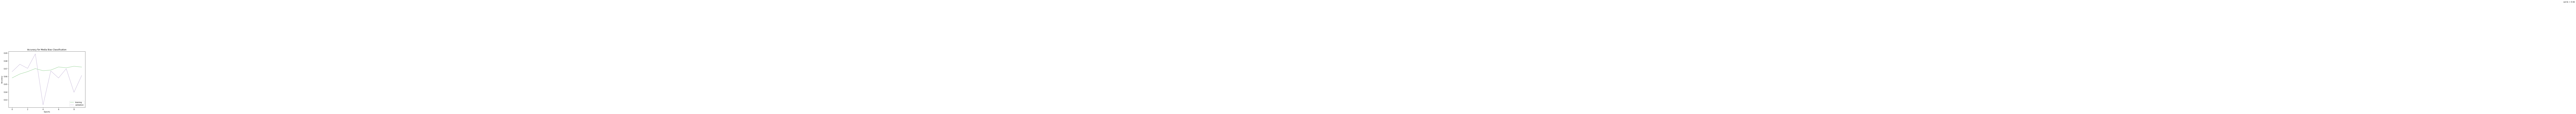

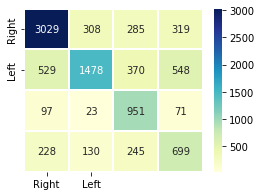

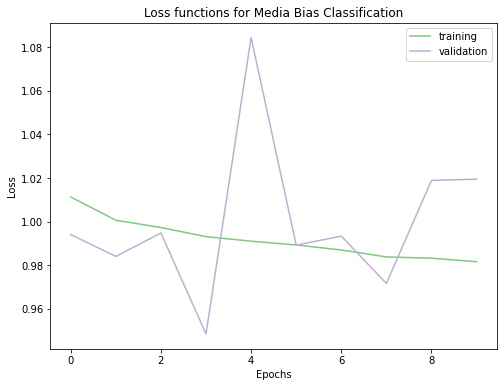

In [61]:
from sklearn.metrics import confusion_matrix
# Plot accuracy curves:
with sns.color_palette("Accent", n_colors=8):
    plt.figure(figsize=(8,6))
    sns.lineplot(data=np.asarray(m_h.history['acc']))
    sns.lineplot(data=np.asarray(m_h.history['val_acc']))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy for Media Bias Classification") # change title here
    plt.legend(labels=['training', 'validation'],loc='lower right')
    plt.text(330,0.755,'val Ac = ' + str(round(f1_score(y_test,pred_new,average='micro'),2))) 
    plt.savefig('outlets_bias_acc.svg',format='svg') # edit file title here

# Plot confusion matrix:
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test,pred_new),annot=True,linewidths=2, cmap="YlGnBu",fmt="g",xticklabels=['Right','Left'],yticklabels=['Right','Left']) # Or change labels to ['outlet1','outlet2','outlet3','outlet4'] for outlet classifier
plt.autoscale()
plt.savefig('confusion_matrix_outlet_bias_bal.png',format='PNG',bbox_inches = "tight") # edit file title here


# Plot loss curves:
with sns.color_palette("Accent", n_colors=8):
    plt.figure(figsize=(8,6))
    sns.lineplot(data=np.asarray(m_h.history['loss']))
    sns.lineplot(data=np.asarray(m_h.history['val_loss']))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss functions for Media Bias Classification") #change title here
    plt.legend(labels=['training', 'validation'])
    plt.savefig('outlets_bias_loss.svg',format='SVG') # edit file title here